In [2]:
import os
import torch
import torch.nn as nn
import PIL
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

f:\Documents\Firma\Projekte\Metirionic\code\deus\khadas\example-network\1_create_and_export_network\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
width = 28
height = 28
image_folder = "./test_images/"


# NOTE1: Images in bmp format are NHWC meaning RGB, RGB, RGB, .... and the array would be defined [batch, height, width, channels]
# NOTE2: NCHW would mean that each color is completely encoded first ie. RRRR GGGG BBBB and it would be defined: [batch, channels, height, width]

In [8]:
class NopNet(nn.Module):
    def __init__(self):
        super(NopNet, self).__init__()
        self.flatten = nn.Flatten(0)

    def forward(self, x):
        x = self.flatten(x)
        # this will create a white stripe in the first 3 * 10 (10px) since we here have NHWC (== RGB RGB RGB ..)
        p = [127]*30 + [0]*2322
        pt = torch.tensor(p)
        x = x + pt
        return x
    
    def name(self):
        return "NopNet"

(28, 28, 3)
tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.uint8)
output after reshape
[[127 127 127 127 127]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0 253]
 [  0   0   0 252  18]]
output after rescale
[[127 127 127 127 127]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0 253]
 [  0   0   0 252  18]]


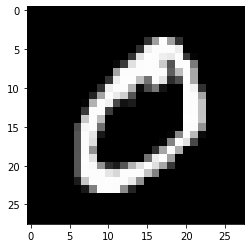

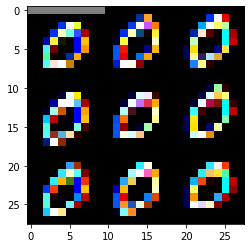

In [9]:
### TEST

nope = NopNet()

for i in range(0,1):
    im = cv.imread(image_folder+"%s.bmp"%i, cv.IMREAD_COLOR)
    
    print(im.shape)
    
    # show original image
    plt.figure()
    plt.imshow(im)
    #print(im[0:5,0:5,0])
    #im = im.astype(float)
    #im = (im - 127.5) / 127.5
    #print(im[0:5,0:5,0])
    #,1,2 ... 2,0,1
    
    # nop image
    
    # NORMAL
    img_tensor = torch.from_numpy(im)
    

    print(img_tensor[0:5,0:5,0])

    # for testing: change image from nhwc (RGB RGB ...) to nchw (RRGGBB) before nw input .. this is probably done automatically by the network
    img_tensor = torch.from_numpy(im.transpose(2,0,1) ) 
    
    res = nope(img_tensor)
       
    
    # show noped image
    # for testing change output from nchw to nchw after nn
    #res_img = np.array(res.tolist()).reshape(28,28,3).transpose(2,1,0).reshape(28,28,3) * 255.
    
    # we suppose transpose is done automatically 
    #res_img = np.array(res.tolist()).reshape(3,28,28).transpose(1,2,0) * 255.
    
    # NORMAL
    # expected imshow format: HxWxC
    res_img = np.array(res.tolist()).reshape(28,28,3)
    print("output after reshape")
    print(res_img[0:5,0:5,0])
    
    #res_img = (res_img * 127.5) + 127.5
    
    res_img = res_img.astype(np.uint8)
    print("output after rescale")
    print(res_img[0:5,0:5,0])

    plt.figure()
    plt.imshow(res_img)




In [10]:
### EXPORT

input_dimension = torch.randn(1,3,28,28,dtype=torch.float)


torch.onnx.export(
                  nope, 
                  input_dimension, 
                  "nopnet.onnx",
                  opset_version=7,
                  verbose=True,
                  export_params=True, 
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes=None,
                  #dynamic_axes={'input': {0: 'batch', 2: 'height', 3: 'width'},  # shape(1,1,28,28)
                  #              'output': {0: 'batch', 1: 'classes'} }  # shape(1,10)
)
          

graph(%input : Float(1, 3, 28, 28, strides=[2352, 784, 28, 1], requires_grad=0, device=cpu)):
  %1 : Long(4, strides=[1], device=cpu) = onnx::Shape(%input) # f:\Documents\Firma\Projekte\Metirionic\code\deus\khadas\example-network\1_create_and_export_network\venv\lib\site-packages\torch\nn\modules\flatten.py:45:0
  %2 : Long(0, strides=[1], device=cpu) = onnx::Slice[axes=[0], ends=[0], starts=[0]](%1) # f:\Documents\Firma\Projekte\Metirionic\code\deus\khadas\example-network\1_create_and_export_network\venv\lib\site-packages\torch\nn\modules\flatten.py:45:0
  %3 : Long(1, strides=[1], device=cpu) = onnx::Constant[value={-1}]() # f:\Documents\Firma\Projekte\Metirionic\code\deus\khadas\example-network\1_create_and_export_network\venv\lib\site-packages\torch\nn\modules\flatten.py:45:0
  %8 : Long(1, strides=[1], requires_grad=0, device=cpu) = onnx::Cast[to=7](%3) # f:\Documents\Firma\Projekte\Metirionic\code\deus\khadas\example-network\1_create_and_export_network\venv\lib\site-packages\torc

C:\Users\scholz\AppData\Local\Temp\ipykernel_12852\2995843070.py:10: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  pt = torch.tensor(p)


## check exported nope model

In [11]:
import onnx

# Load the ONNX model
model = onnx.load("nopnet.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a Human readable representation of the graph
onnx.helper.printable_graph(model.graph)

'graph torch-jit-export (\n  %input[FLOAT, 1x3x28x28]\n) {\n  %onnx::Slice_1 = Shape(%input)\n  %onnx::Concat_2 = Slice[axes = [0], ends = [0], starts = [0]](%onnx::Slice_1)\n  %onnx::Cast_3 = Constant[value = <Tensor>]()\n  %onnx::Concat_8 = Cast[to = 7](%onnx::Cast_3)\n  %onnx::Reshape_4 = Concat[axis = 0](%onnx::Concat_2, %onnx::Concat_8)\n  %onnx::Add_5 = Reshape(%input, %onnx::Reshape_4)\n  %onnx::Add_6 = Constant[value = <Tensor>]()\n  %output = Add(%onnx::Add_5, %onnx::Add_6)\n  return %output\n}'